## Import pakages

In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import random

## Read images

In [2]:
path = '...'

img_rows = 64
img_cols = 64
channels = 3

X = []

for i in os.listdir(path):
    image = cv2.imread(path + '/' + i)
    image = image.astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_rows, img_cols))
    X.append(image)  

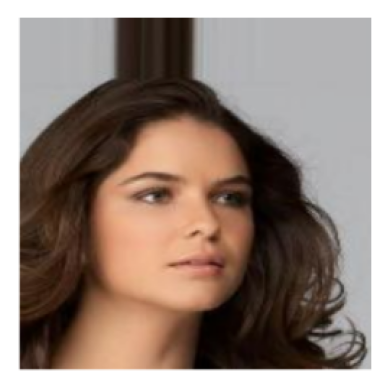

In [8]:
i = X[0]
plt.figure()
plt.axis('off')
plt.imshow(i)
plt.show()

## Set images in random order

In [9]:
random.shuffle(X)

## Convert to grayscale 

In [10]:
X_gray = np.array([cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY) for i in range(len(X))])

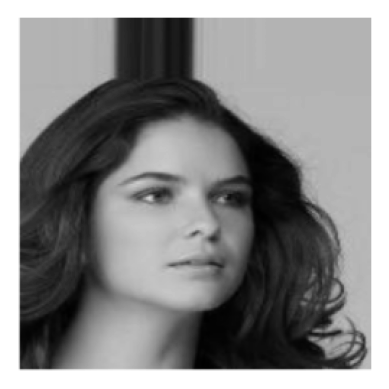

In [11]:
plt.figure()
plt.axis('off')
plt.imshow(X_gray[0], cmap='gray')
plt.show()

## Train Test Split 

In [12]:
#split in proportion 80/20
percent = int(len(X)*0.8)
X_train, X_test = np.array(X[:percent]), np.array(X[percent:])
X_train_gray, X_test_gray = X_gray[:percent], X_gray[percent:]

## Images normalization

In [13]:
#RGB images
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

#Grayscale images
X_train_gray = X_train_gray.astype('float32')/255
X_test_gray = X_test_gray.astype('float32')/255

## History plot

In [ ]:
def plot_history(history):
    #Plot the Loss Curves
    plt.figure(figsize=[8,6])

    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)

    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()

## Network's parameters

In [14]:
input_shape = (img_rows, img_cols, 1)
batch_size = 128
kernel_size = 3
strides = 2
activation = 'relu'
padding = 'same'
latent_dim = 256
layer_filters = [64, 128, 256, 512]

## Encoder

In [15]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              activation=activation,
              padding=padding)(x)
    
shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 latent_vector (Dense)       (None, 256)               67109120  
                                                                 
Total params: 67,478,784
Trainable params: 67,478,784
Non-t

## Decoder

In [16]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       activation=activation,
                       padding=padding)(x)
    
outputs = Conv2DTranspose(filters=channels, 
                         kernel_size=kernel_size,
                         activation='sigmoid',
                         padding=padding,
                         name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 262144)            67371008  
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 128)    295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 256, 256, 64)     7379

## Autoencoder

In [17]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 1)]     0         
                                                                 
 encoder (Functional)        (None, 256)               67478784  
                                                                 
 decoder (Functional)        (None, 256, 256, 3)       68331651  
                                                                 
Total params: 135,810,435
Trainable params: 135,810,435
Non-trainable params: 0
_________________________________________________________________


## Learning rate reducer

In [22]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                             cooldown=0,
                             patience=5,
                             verbouse=1,
                             min_lr=0.5e-6)

## Compilation

In [24]:
autoencoder.compile(loss='mse', optimizer='adam')

## Fit

In [ ]:
history = autoencoder.fit(X_train_gray,
               X_train,
               validation_data=(X_test_gray, X_test),
               epochs=20,
               batch_size=batch_size,
               callbacks=lr_reducer)

Epoch 1/20
317/317 [==============================] - 59s 145ms/step - loss: 0.0287 - val_loss: 0.0165 - lr: 0.0010
Epoch 2/20
317/317 [==============================] - 45s 142ms/step - loss: 0.0144 - val_loss: 0.0129 - lr: 0.0010
Epoch 3/20
317/317 [==============================] - 43s 137ms/step - loss: 0.0122 - val_loss: 0.0117 - lr: 0.0010
Epoch 4/20
317/317 [==============================] - 43s 137ms/step - loss: 0.0113 - val_loss: 0.0108 - lr: 0.0010
Epoch 5/20
317/317 [==============================] - 43s 137ms/step - loss: 0.0106 - val_loss: 0.0105 - lr: 0.0010
Epoch 6/20
317/317 [==============================] - 43s 137ms/step - loss: 0.0101 - val_loss: 0.0104 - lr: 0.0010
Epoch 7/20
317/317 [==============================] - 43s 137ms/step - loss: 0.0098 - val_loss: 0.0098 - lr: 0.0010
Epoch 8/20
317/317 [==============================] - 43s 136ms/step - loss: 0.0095 - val_loss: 0.0095 - lr: 0.0010
Epoch 9/20
317/317 [==============================] - 44s 138ms/step - loss: 0.0092 - val_loss: 0.0098 - lr: 0.0010
Epoch 10/20
317/317 [==============================] - 43s 137ms/step - loss: 0.0090 - val_loss: 0.0094 - lr: 0.0010
Epoch 11/20
317/317 [==============================] - 44s 140ms/step - loss: 0.0088 - val_loss: 0.0093 - lr: 0.0010
Epoch 12/20
317/317 [==============================] - 43s 137ms/step - loss: 0.0086 - val_loss: 0.0097 - lr: 0.0010
Epoch 13/20
317/317 [==============================] - 44s 140ms/step - loss: 0.0083 - val_loss: 0.0095 - lr: 0.0010
Epoch 14/20
317/317 [==============================] - 44s 140ms/step - loss: 0.0080 - val_loss: 0.0097 - lr: 0.0010
Epoch 15/20
317/317 [==============================] - 43s 136ms/step - loss: 0.0077 - val_loss: 0.0095 - lr: 0.0010
Epoch 16/20
317/317 [==============================] - 44s 140ms/step - loss: 0.0068 - val_loss: 0.0092 - lr: 3.1623e-04
Epoch 17/20
317/317 [==============================] - 43s 136ms/step - loss: 0.0066 - val_loss: 0.0091 - lr: 3.1623e-04
Epoch 18/20
317/317 [==============================] - 43s 136ms/step - loss: 0.0064 - val_loss: 0.0091 - lr: 3.1623e-04
Epoch 19/20
317/317 [==============================] - 43s 137ms/step - loss: 0.0063 - val_loss: 0.0091 - lr: 3.1623e-04
Epoch 20/20
317/317 [==============================] - 43s 137ms/step - loss: 0.0062 - val_loss: 0.0091 - lr: 3.1623e-04

In [ ]:
plot_history(history)

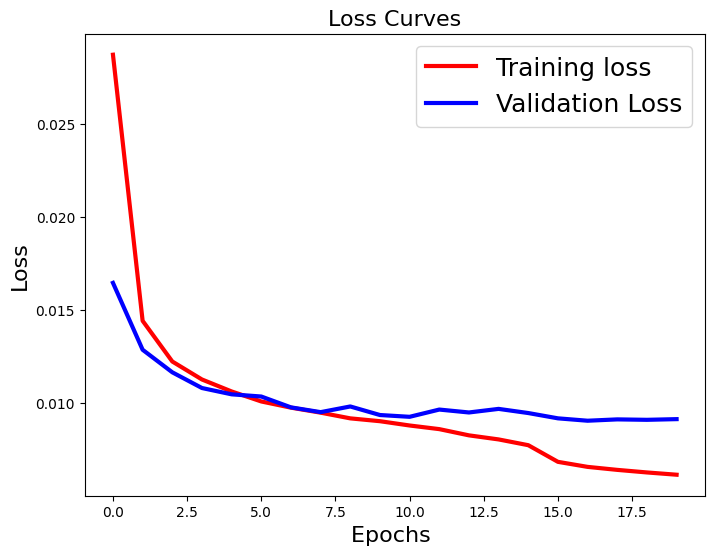

In [30]:
X_decoded = autoencoder.predict(X_test_gray[:12])

1/1 [==============================] - 0s 130ms/step


In [ ]:
imgs = X_test[:12]
imgs = imgs.reshape((3, 4, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation='none')

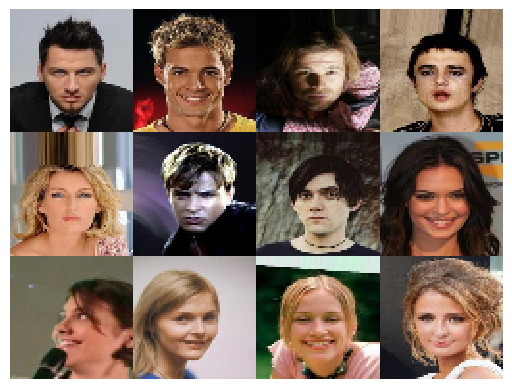

In [ ]:
imgs = X_decoded
imgs = imgs.reshape((3, 4, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.title('Prediction')
plt.axis('off')
plt.imshow(imgs, interpolation='none')

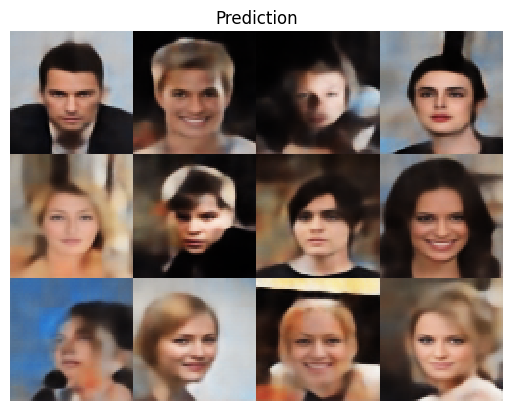

## Thoughts

First of all, the autoencoder is heavily overtrained. In the next step im going to test different methods of regularization.  

Secondly, I'm starting to think that this dataset was not the best choice for this task.

In summary, there are still a lot of things to improve and I will return to this in the coming weeks. Despite the specific dataset, I hope to get satisfactory results.